In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import make_scorer, root_mean_squared_error, mean_absolute_error, precision_score, recall_score, r2_score, confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

import optuna

from joblib import Parallel, delayed

# Регрессия

In [2]:
RAW_FEATS = 'regression_raw_feats.csv'
RAW_TARGET = 'regression_raw_target.csv'
PROCESSED_FEATS = 'regression_processed_feats.csv'
PROCESSED_TARGET = 'regression_processed_target.csv'

In [3]:
df_feats_raw = pd.read_csv(RAW_FEATS)
df_target_raw = pd.read_csv(RAW_TARGET)
df_feats_processed = pd.read_csv(PROCESSED_FEATS)
df_target_processed = pd.read_csv(PROCESSED_TARGET)

In [4]:
def evaluate(metrics, y_test, y_pred, round_num):
    for metric in metrics:
        print(f'Model score for metric "{metric.__name__}": {round(metric(y_test, y_pred), round_num)}')

    plt.scatter(y_test, y_pred, alpha=0.7, label='Predictions')
    line_coords = np.linspace(np.min(y_test), np.max(y_test), 100)
    plt.plot(line_coords, line_coords, color='red', linestyle='--', linewidth=2, label='Perfect prediction')
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.title('Actual vs predicted values')
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
eval_metrics = [mean_absolute_error, root_mean_squared_error, r2_score]
random_state = 42
test_size = 0.2

round_num = 4

optuna_metric = root_mean_squared_error
optuna_direction = "minimize"
n_trials = 30
cv = 5

## Готовая модель

In [6]:
model_class = DecisionTreeRegressor

### Бейзлайн

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_raw, df_target_raw, test_size = test_size, random_state = random_state)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [8]:
model = model_class(random_state = random_state)

model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [9]:
y_pred = model.predict(X_test)

Model score for metric "mean_absolute_error": 3.4392
Model score for metric "root_mean_squared_error": 6.4397
Model score for metric "r2_score": 0.0534


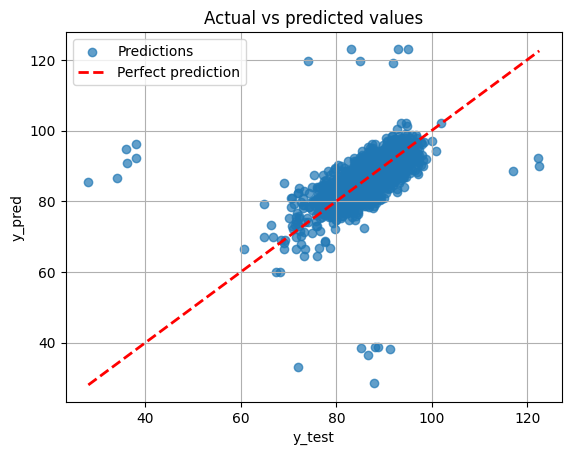

In [10]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

### Улучшенный бейзлайн

#### Улучшение за счёт препроцессинга

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_processed, df_target_processed, test_size = test_size, random_state = random_state)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [12]:
model = model_class(random_state = random_state)

model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [13]:
y_pred = model.predict(X_test)

Model score for metric "mean_absolute_error": 3.5629
Model score for metric "root_mean_squared_error": 6.6447
Model score for metric "r2_score": -0.3828


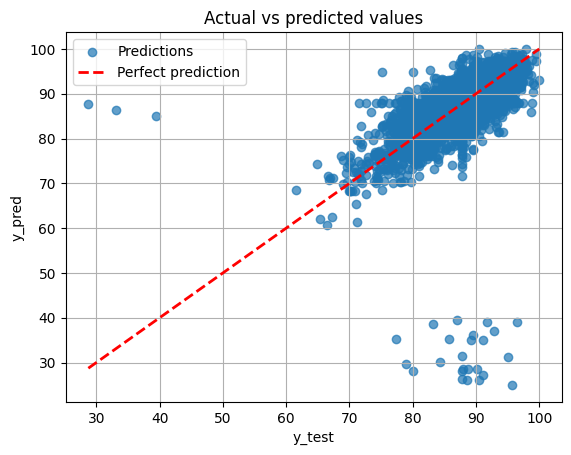

In [14]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

#### Дополнительное улучшение за счёт подбора параметров на cross-val

In [15]:
def objective(trial):
    optuna_params = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.5),

        'random_state': trial.suggest_categorical('random_state', [random_state]),
    }

    trial_model = model_class(**optuna_params)
    
    score = cross_val_score(trial_model, X_train, y_train, cv=cv, scoring=make_scorer(optuna_metric), n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction=optuna_direction, sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective, n_trials=n_trials)

print(f"Лучшие параметры для модели: {study.best_params}")
print(f"Лучшая метрика ({optuna_metric.__name__}): {round(study.best_value,round_num)}")

best_model = model_class(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-12-09 22:37:14,320] A new study created in memory with name: no-name-1d76f75e-2592-4474-b9ee-a66c44cdbea4
[I 2025-12-09 22:37:15,822] Trial 0 finished with value: 4.789382283664274 and parameters: {'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_features': 0.6387926357773329, 'min_impurity_decrease': 0.07800932022121826, 'random_state': 42}. Best is trial 0 with value: 4.789382283664274.
[I 2025-12-09 22:37:16,900] Trial 1 finished with value: 5.028174605979757 and parameters: {'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 18, 'max_features': 0.6410035105688879, 'min_impurity_decrease': 0.35403628889802274, 'random_state': 42}. Best is trial 0 with value: 4.789382283664274.
[I 2025-12-09 22:37:17,820] Trial 2 finished with value: 5.774087330980089 and parameters: {'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 17, 'max_features': 0.29110519961044856, 'min_impurity_decrease': 0.09091248360355031, 'random_state': 42}. Best is tria

Лучшие параметры для модели: {'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_features': 0.7714157288516673, 'min_impurity_decrease': 0.0020730763700767957, 'random_state': 42}
Лучшая метрика (root_mean_squared_error): 4.6349


DecisionTreeRegressor(max_depth=9, max_features=0.7714157288516673,
                      min_impurity_decrease=0.0020730763700767957,
                      min_samples_leaf=15, min_samples_split=20,
                      random_state=42)

In [16]:
y_pred = best_model.predict(X_test)

Model score for metric "mean_absolute_error": 2.4621
Model score for metric "root_mean_squared_error": 3.4768
Model score for metric "r2_score": 0.6214


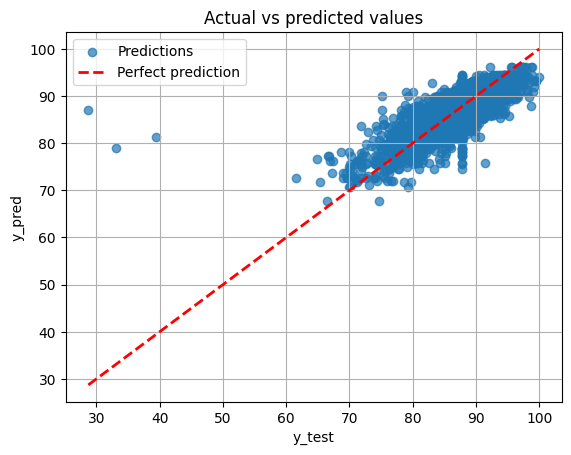

In [17]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

## Своя модель

In [ ]:
class MyDecisionTreeRegressor:
    """
    Parameters
    -----------
    max_depth : int, default=None
    min_samples_split : int, default=2
    min_samples_leaf : int, default=1
    max_features : int, float or None, default=None
    min_impurity_decrease : float, default=0.0
    random_state : int, default=None
    """
    def __init__(self, max_depth: int = None, min_samples_split: int = 2, min_samples_leaf: int = 1, 
            max_features = None, min_impurity_decrease: float = 0.0, random_state: int = None):

        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.min_impurity_decrease = min_impurity_decrease
        self.random_state = random_state

        self.tree_ = None
        self.n_features_ = None


    def fit(self, X: np.ndarray, y: np.ndarray) -> 'MyDecisionTreeRegressor':
        X = np.asarray(X, dtype = float)
        y = np.asarray(y, dtype = float)

        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must have the same number of samples.")
        
        self.n_features_ = X.shape[1]

        self.rng_ = np.random.default_rng(self.random_state)

        if isinstance(self.max_features, int):
            n_features_to_consider = min(self.max_features, self.n_features_)
        elif isinstance(self.max_features, float):
            n_features_to_consider = int(self.max_features * self.n_features_)
        else:
            n_features_to_consider = self.n_features_
        
        self.tree_ = self._build_tree(X, y, depth=0, n_features_to_consider=n_features_to_consider)
        return self

    def _build_tree(self, X, y, depth, n_features_to_consider):
        n_samples, n_features = X.shape
        node_impurity = np.var(y)

        is_leaf = (
            (self.max_depth is not None and depth >= self.max_depth) or
            (n_samples < self.min_samples_split) or
            (node_impurity == 0)
        )
        if is_leaf:
            return {'value': np.mean(y), 'is_leaf': True}

        best_impurity_decrease = 0
        best_split = None

        feature_indices = self.rng_.choice(n_features, n_features_to_consider, replace=False)

        for feature_index in feature_indices:
            X_feature = X[:, feature_index]
            unique_values = np.unique(X_feature)
            if len(unique_values) <= 1:
                continue

            thresholds = (unique_values[:-1] + unique_values[1:]) / 2

            for threshold in thresholds:
                left_indices = X_feature <= threshold
                right_indices = X_feature > threshold

                if (np.sum(left_indices) < self.min_samples_leaf or
                    np.sum(right_indices) < self.min_samples_leaf):
                    continue
                
                y_left, y_right = y[left_indices], y[right_indices]
                n_left, n_right = len(y_left), len(y_right)

                impurity_left = np.var(y_left)
                impurity_right = np.var(y_right)
                weighted_child_impurity = (n_left / n_samples) * impurity_left + (n_right / n_samples) * impurity_right
                impurity_decrease = node_impurity - weighted_child_impurity

                if impurity_decrease > best_impurity_decrease:
                    best_impurity_decrease = impurity_decrease
                    best_split = {
                        'feature_index': feature_index,
                        'threshold': threshold,
                        'left_indices': left_indices,
                        'right_indices': right_indices
                    }

        if best_split is None or best_impurity_decrease < self.min_impurity_decrease:
            return {'value': np.mean(y), 'is_leaf': True}

        left_subtree = self._build_tree(
            X[best_split['left_indices']], 
            y[best_split['left_indices']], 
            depth + 1, 
            n_features_to_consider
        )
        right_subtree = self._build_tree(
            X[best_split['right_indices']], 
            y[best_split['right_indices']], 
            depth + 1, 
            n_features_to_consider
        )

        return {
            'feature_index': best_split['feature_index'],
            'threshold': best_split['threshold'],
            'left': left_subtree,
            'right': right_subtree,
            'is_leaf': False
        }

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.tree_ is None:
            raise RuntimeError("You must call fit() before predict().")
        
        X = np.asarray(X)
        predictions = [self._predict_one(sample, self.tree_) for sample in X]
        return np.array(predictions)

    def _predict_one(self, sample, node):
        if node['is_leaf']:
            return node['value']
        
        if sample[node['feature_index']] <= node['threshold']:
            return self._predict_one(sample, node['left'])
        else:
            return self._predict_one(sample, node['right'])

    def get_params(self, deep: bool = True) -> dict:
        return {
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf,
            'max_features': self.max_features,
            'min_impurity_decrease': self.min_impurity_decrease,
            'random_state': self.random_state,
        }

    def set_params(self, **params):
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Invalid parameter {key} for MyDecisionTreeRegressor")
        return self

In [19]:
model_class = MyDecisionTreeRegressor

### Бейзлайн

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_raw, df_target_raw, test_size = test_size, random_state = random_state)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [21]:
model = model_class(random_state = random_state)

model.fit(X_train, y_train)

In [22]:
y_pred = model.predict(X_test)

Model score for metric "mean_absolute_error": 3.5017
Model score for metric "root_mean_squared_error": 6.6991
Model score for metric "r2_score": -0.0245


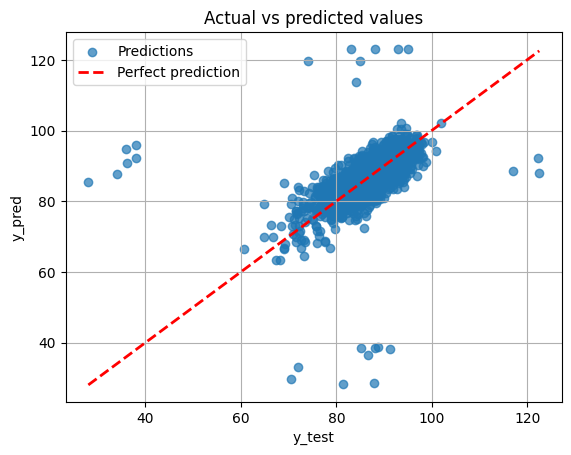

In [23]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

Значения приблизительно совпадают с библиотечной моделью, незначительно хуже.

### Улучшенный бейзлайн

#### Улучшение за счёт препроцессинга

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_processed, df_target_processed, test_size = test_size, random_state = random_state)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [25]:
model = model_class(random_state = random_state)

model.fit(X_train, y_train)

In [26]:
y_pred = model.predict(X_test)

Model score for metric "mean_absolute_error": 3.46
Model score for metric "root_mean_squared_error": 6.0698
Model score for metric "r2_score": -0.1539


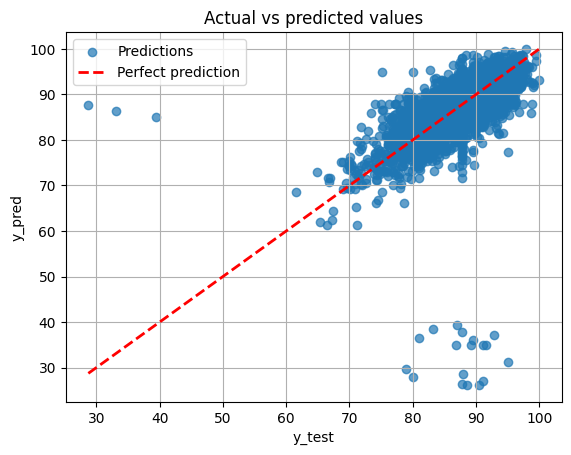

In [27]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

Результат чуть лучше, чем у библиотечной модели, но незначительно (десятые - сотые).

#### Дополнительное улучшение за счёт подбора параметров на cross-val

In [28]:
def objective(trial):
    optuna_params = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.5),

        'random_state': trial.suggest_categorical('random_state', [random_state]),
    }

    trial_model = model_class(**optuna_params)
    
    score = cross_val_score(trial_model, X_train, y_train, cv=cv, scoring=make_scorer(optuna_metric), n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction=optuna_direction, sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective, n_trials=n_trials)

print(f"Лучшие параметры для модели: {study.best_params}")
print(f"Лучшая метрика ({optuna_metric.__name__}): {round(study.best_value,round_num)}")

best_model = model_class(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-12-09 22:38:38,815] A new study created in memory with name: no-name-4d18f2b0-0a8e-4999-a151-ab1ecb86c6a2
[I 2025-12-09 22:38:45,873] Trial 0 finished with value: 4.6478419732359075 and parameters: {'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_features': 0.6387926357773329, 'min_impurity_decrease': 0.07800932022121826, 'random_state': 42}. Best is trial 0 with value: 4.6478419732359075.
[I 2025-12-09 22:38:49,723] Trial 1 finished with value: 4.907731613309827 and parameters: {'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 18, 'max_features': 0.6410035105688879, 'min_impurity_decrease': 0.35403628889802274, 'random_state': 42}. Best is trial 0 with value: 4.6478419732359075.
[I 2025-12-09 22:38:50,423] Trial 2 finished with value: 5.316238359175342 and parameters: {'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 17, 'max_features': 0.29110519961044856, 'min_impurity_decrease': 0.09091248360355031, 'random_state': 42}. Best is t

Лучшие параметры для модели: {'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': 0.7185155890106618, 'min_impurity_decrease': 0.18660351245564136, 'random_state': 42}
Лучшая метрика (root_mean_squared_error): 4.6144


In [29]:
y_pred = best_model.predict(X_test)

Model score for metric "mean_absolute_error": 2.4888
Model score for metric "root_mean_squared_error": 3.5632
Model score for metric "r2_score": 0.6023


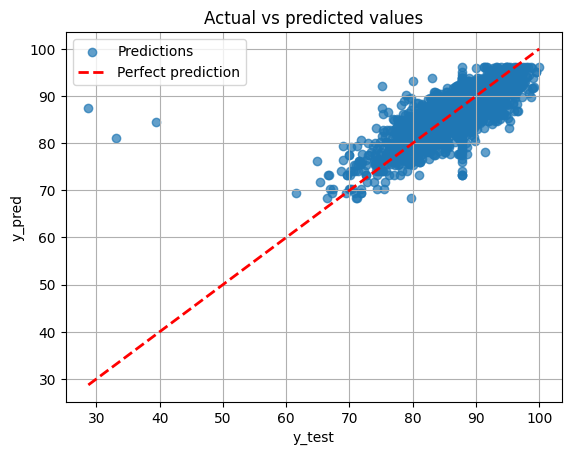

In [30]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

Результаты незначительно хуже, чем у библиотечной модели (десятые - сотые).

# Классификация

In [31]:
RAW_FEATS = 'classification_raw_feats.csv'
RAW_TARGET = 'classification_raw_target.csv'
PROCESSED_FEATS = 'classification_processed_feats.csv'
PROCESSED_TARGET = 'classification_processed_target.csv'

In [32]:
df_feats_raw = pd.read_csv(RAW_FEATS)
df_target_raw = pd.read_csv(RAW_TARGET)
df_feats_processed = pd.read_csv(PROCESSED_FEATS)
df_target_processed = pd.read_csv(PROCESSED_TARGET)

In [33]:
def evaluate(y_test, y_pred_class, y_pred_proba, round_num):

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
    roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])

    print(f"ROC AUC: {round(roc_auc,round_num)}", '\n')

    f1 = f1_score(y_test, y_pred_class)
    precision = precision_score(y_test, y_pred_class)
    recall = recall_score(y_test, y_pred_class)

    print(f"Precision: {round(precision,round_num)}")
    print(f"Recall: {round(recall,round_num)}")
    print(f"F1-Score: {round(f1,round_num)}")

    plt.plot(fpr, tpr, label=f'ROC curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

    cm = confusion_matrix(y_test, y_pred_class)
    sns.heatmap(cm, annot=True, fmt = 'd', cmap='Blues', cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion matrix')
    plt.show()

In [34]:
eval_metrics = [f1_score, roc_auc_score]
random_state = 42
test_size = 0.2

round_num = 4

optuna_metric = f1_score
optuna_direction = "maximize"
n_trials = 100
cv = 5

max_depth = 10

## Готовая модель

In [35]:
model_class = DecisionTreeClassifier

### Бейзлайн

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_raw, df_target_raw, test_size = test_size, random_state = random_state)

In [37]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [38]:
model = model_class(max_depth = max_depth, random_state = random_state)

model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [39]:
y_pred_class = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

ROC AUC: 0.9539 

Precision: 0.9153
Recall: 0.7067
F1-Score: 0.7976


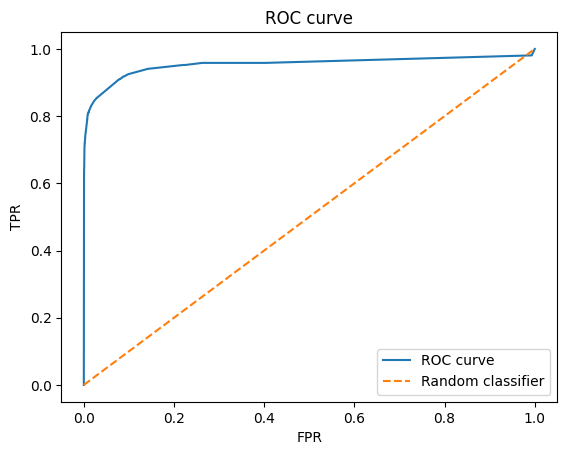

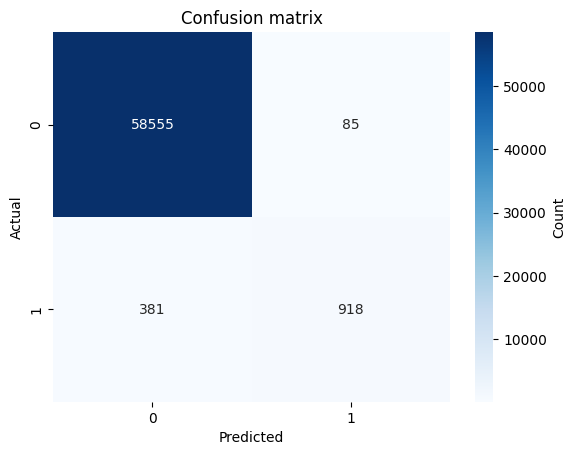

In [40]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

### Улучшенный бейзлайн

#### Улучшение за счёт препроцессинга

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_processed, df_target_processed, test_size = test_size, random_state = random_state)

In [42]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [43]:
model = model_class(max_depth = max_depth, random_state = random_state)

model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [44]:
y_pred_class = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

ROC AUC: 0.9687 

Precision: 0.9463
Recall: 0.746
F1-Score: 0.8343


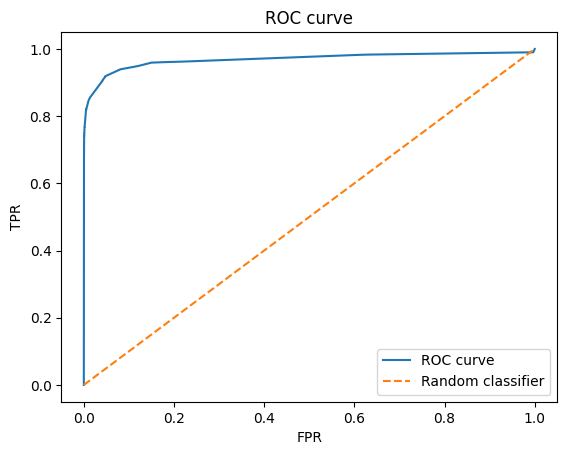

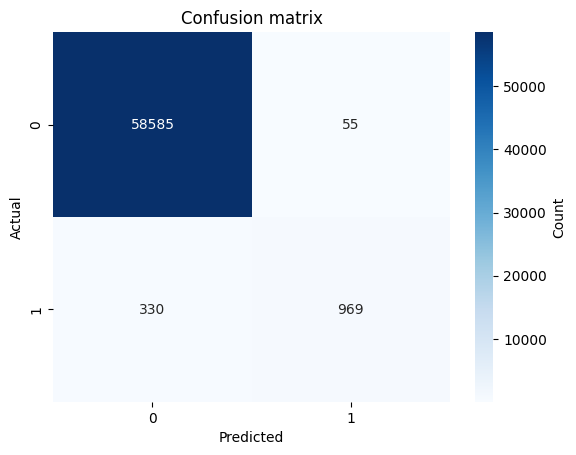

In [45]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

#### Дополнительное улучшение за счёт подбора параметров на cross-val

In [46]:
def objective(trial):
    optuna_params = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.5),

        'random_state': trial.suggest_categorical('random_state', [random_state]),
    }

    trial_model = model_class(**optuna_params)
    
    score = cross_val_score(trial_model, X_train, y_train, cv=cv, scoring=make_scorer(optuna_metric), n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction=optuna_direction, sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective, n_trials=n_trials)

print(f"Лучшие параметры для модели: {study.best_params}")
print(f"Лучшая метрика ({optuna_metric.__name__}): {round(study.best_value,round_num)}")

best_model = model_class(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-12-09 22:42:31,487] A new study created in memory with name: no-name-fd4cb7b0-ad36-437d-9326-d450575ec9e8
[I 2025-12-09 22:42:31,812] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_features': 0.6387926357773329, 'min_impurity_decrease': 0.07800932022121826, 'random_state': 42}. Best is trial 0 with value: 0.0.
[I 2025-12-09 22:42:32,129] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 18, 'max_features': 0.6410035105688879, 'min_impurity_decrease': 0.35403628889802274, 'random_state': 42}. Best is trial 0 with value: 0.0.
[I 2025-12-09 22:42:32,398] Trial 2 finished with value: 0.0 and parameters: {'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 17, 'max_features': 0.29110519961044856, 'min_impurity_decrease': 0.09091248360355031, 'random_state': 42}. Best is trial 0 with value: 0.0.
[I 2025-12-09 22:42:32,702] Trial 3 finished with

Лучшие параметры для модели: {'max_depth': 19, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 0.9421776782774816, 'min_impurity_decrease': 0.0004669438154988567, 'random_state': 42}
Лучшая метрика (f1_score): 0.7435


DecisionTreeClassifier(max_depth=19, max_features=0.9421776782774816,
                       min_impurity_decrease=0.0004669438154988567,
                       min_samples_leaf=5, min_samples_split=11,
                       random_state=42)

In [47]:
y_pred_class = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

ROC AUC: 0.8594 

Precision: 0.8445
Recall: 0.652
F1-Score: 0.7359


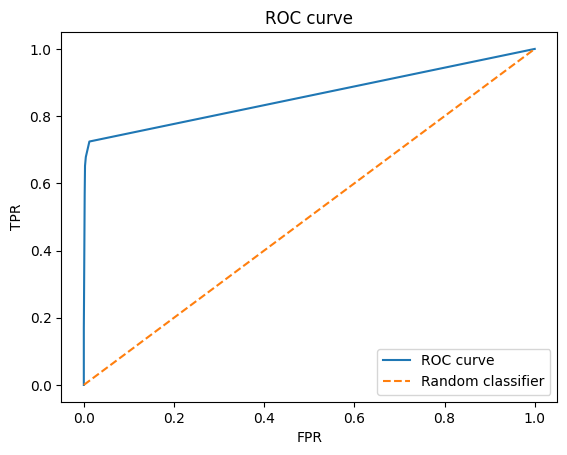

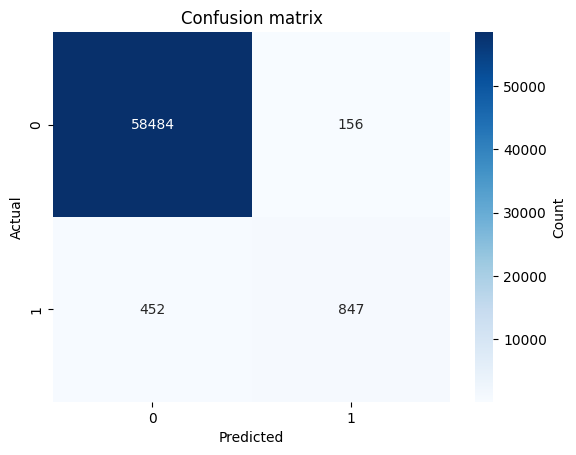

In [48]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

## Своя модель

In [ ]:
class MyDecisionTreeClassifier:
    """
    Parameters
    -----------
    max_depth : int, default=None
    min_samples_split : int, default=2
    min_samples_leaf : int, default=1
    max_features : int, float or None, default=None
    min_impurity_decrease : float, default=0.0
    n_jobs : int, default=1
    random_state: int, default = None
    """
    def __init__(self, max_depth: int = None, min_samples_split: int = 2, min_samples_leaf: int = 1, 
            max_features=None, min_impurity_decrease: float = 0.0, n_jobs: int = 1, random_state: int = None):

        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.min_impurity_decrease = min_impurity_decrease
        self.n_jobs = n_jobs
        self.random_state = random_state

        self.tree_ = None
        self.n_features_ = None
        self.classes_ = None
        self.n_classes_ = None
        self.X_ = None
        self.y_ = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'MyDecisionTreeClassifier':
        X = np.asarray(X, dtype = float)
        y = np.asarray(y, dtype = float)

        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must have the same number of samples.")

        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        self.n_features_ = X.shape[1]
        self.X_ = X
        self.y_ = y

        self.rng_ = np.random.default_rng(self.random_state)

        if isinstance(self.max_features, int):
            n_features_to_consider = min(self.max_features, self.n_features_)
        elif isinstance(self.max_features, float):
            n_features_to_consider = max(1, int(self.max_features * self.n_features_))
        else:
            n_features_to_consider = self.n_features_
        
        initial_indices = np.arange(X.shape[0])
        self.tree_ = self._build_tree(initial_indices, depth=0, n_features_to_consider=n_features_to_consider)
        return self

    def _gini(self, y_indices):
        n_samples = len(y_indices)
        if n_samples == 0:
            return 0
        
        gini = 1.0
        y_subset = self.y_[y_indices]
        for c in self.classes_:
            p = np.sum(y_subset == c) / n_samples
            gini -= p**2
        return gini

    def _find_best_split_for_feature(self, indices, feature_index):
        X_feature = self.X_[indices, feature_index]
        y_subset = self.y_[indices]
        
        sorted_indices = np.argsort(X_feature)
        X_sorted = X_feature[sorted_indices]
        y_sorted = y_subset[sorted_indices]
        
        n_samples = len(indices)
        if n_samples < 2 * self.min_samples_leaf or np.all(X_sorted == X_sorted[0]):
            return None, 0

        parent_gini = self._gini(indices)
        best_impurity_decrease = 0
        best_threshold = None
        
        right_counts = np.bincount(y_sorted, minlength=self.n_classes_)
        left_counts = np.zeros(self.n_classes_, dtype=int)

        for i in range(n_samples - 1):
            label = y_sorted[i]
            left_counts[label] += 1
            right_counts[label] -= 1
            
            if X_sorted[i] == X_sorted[i+1]:
                continue
            
            if i + 1 < self.min_samples_leaf or n_samples - (i + 1) < self.min_samples_leaf:
                continue

            n_left = i + 1
            n_right = n_samples - n_left
            gini_left = 1.0 - np.sum((left_counts / n_left)**2)
            gini_right = 1.0 - np.sum((right_counts / n_right)**2)
            
            weighted_child_impurity = (n_left / n_samples) * gini_left + (n_right / n_samples) * gini_right
            impurity_decrease = parent_gini - weighted_child_impurity
            
            if impurity_decrease > best_impurity_decrease:
                best_impurity_decrease = impurity_decrease
                best_threshold = (X_sorted[i] + X_sorted[i+1]) / 2
                
        return best_threshold, best_impurity_decrease

    def _build_tree(self, indices, depth, n_features_to_consider):
        n_samples = len(indices)
        
        if (self.max_depth is not None and depth >= self.max_depth) or \
           (n_samples < self.min_samples_split) or \
           (len(np.unique(self.y_[indices])) == 1):
            class_counts = np.bincount(self.y_[indices], minlength=self.n_classes_)
            return {'is_leaf': True, 'class': self.classes_[np.argmax(class_counts)], 'class_counts': class_counts}

        best_feature = None
        best_threshold = None
        best_impurity_decrease = 0
        
        feature_indices = self.rng_.choice(self.n_features_, n_features_to_consider, replace=False)

        results = Parallel(n_jobs=self.n_jobs)(
            delayed(self._find_best_split_for_feature)(indices, i) for i in feature_indices
        )
        
        for i, (threshold, impurity_decrease) in zip(feature_indices, results):
            if impurity_decrease > best_impurity_decrease:
                best_impurity_decrease = impurity_decrease
                best_feature = i
                best_threshold = threshold

        if best_impurity_decrease < self.min_impurity_decrease or best_threshold is None:
            class_counts = np.bincount(self.y_[indices], minlength=self.n_classes_)
            return {'is_leaf': True, 'class': self.classes_[np.argmax(class_counts)], 'class_counts': class_counts}

        left_indices = indices[self.X_[indices, best_feature] <= best_threshold]
        right_indices = indices[self.X_[indices, best_feature] > best_threshold]
        
        left_subtree = self._build_tree(left_indices, depth + 1, n_features_to_consider)
        right_subtree = self._build_tree(right_indices, depth + 1, n_features_to_consider)

        return {
            'is_leaf': False,
            'feature_index': best_feature,
            'threshold': best_threshold,
            'left': left_subtree,
            'right': right_subtree
        }

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.tree_ is None:
            raise RuntimeError("You must call fit() before predict().")
        
        X = np.asarray(X)
        predictions = [self._predict_one(sample, self.tree_) for sample in X]
        return np.array(predictions)

    def _predict_one(self, sample, node):
        if node['is_leaf']:
            return node['class']
        
        if sample[node['feature_index']] <= node['threshold']:
            return self._predict_one(sample, node['left'])
        else:
            return self._predict_one(sample, node['right'])
            
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        if self.tree_ is None:
            raise RuntimeError("You must call fit() before predict_proba().")
        
        X = np.asarray(X)
        probas = [self._predict_proba_one(sample, self.tree_) for sample in X]
        return np.array(probas)

    def _predict_proba_one(self, sample, node):
        if node['is_leaf']:
            total_samples = np.sum(node['class_counts'])
            if total_samples == 0:
                return np.full(self.n_classes_, 1 / self.n_classes_)
            return np.array(node['class_counts']) / total_samples
        
        if sample[node['feature_index']] <= node['threshold']:
            return self._predict_proba_one(sample, node['left'])
        else:
            return self._predict_proba_one(sample, node['right'])

    def get_params(self, deep: bool = True) -> dict:
        return {
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf,
            'max_features': self.max_features,
            'min_impurity_decrease': self.min_impurity_decrease,
            'random_state': self.random_state,
            'n_jobs': self.n_jobs,
        }

    def set_params(self, **params):
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Invalid parameter {key} for MyDecisionTreeClassifier")
        return self

In [50]:
model_class = MyDecisionTreeClassifier

### Бейзлайн

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_raw, df_target_raw, test_size = test_size, random_state = random_state)

In [52]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [53]:
model = model_class(max_depth = max_depth, random_state = random_state, n_jobs=-1)

model.fit(X_train, y_train)

In [54]:
y_pred_class = model.predict(X_test)

In [55]:
y_pred_proba = model.predict_proba(X_test)

ROC AUC: 0.9585 

Precision: 0.9175
Recall: 0.7105
F1-Score: 0.8009


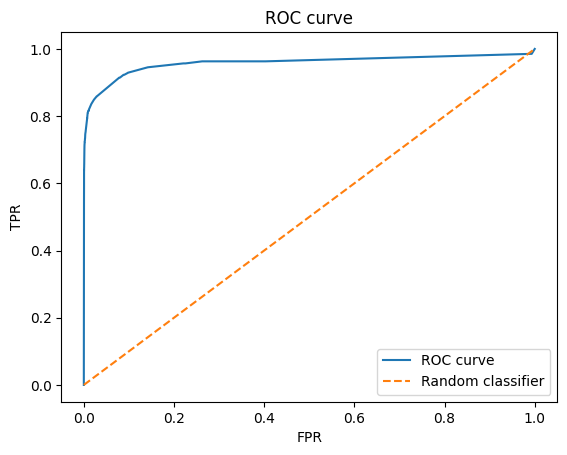

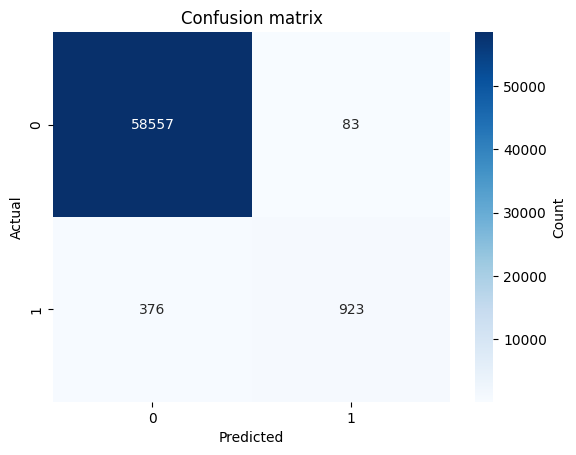

In [56]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

Совпадает с результатами библиотечной модели до сотых.

### Улучшенный бейзлайн

#### Улучшение за счёт препроцессинга

In [57]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_processed, df_target_processed, test_size = test_size, random_state = random_state)

In [58]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [59]:
model = model_class(max_depth = max_depth, random_state = random_state, n_jobs=-1)

model.fit(X_train, y_train)

In [60]:
y_pred_class = model.predict(X_test)

In [61]:
y_pred_proba = model.predict_proba(X_test)

ROC AUC: 0.9702 

Precision: 0.9455
Recall: 0.7475
F1-Score: 0.8349


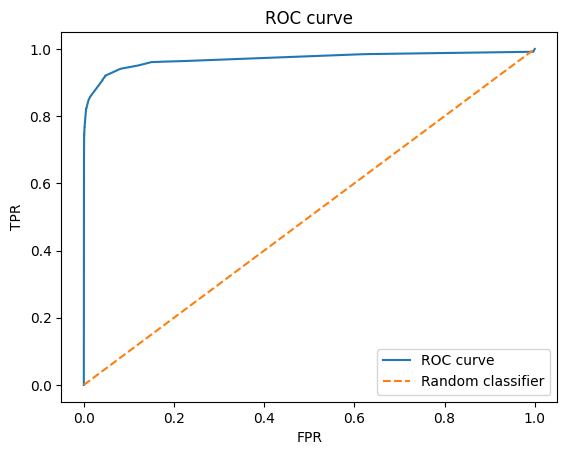

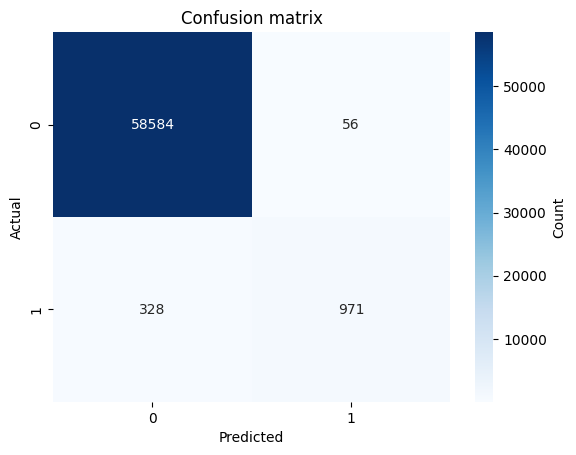

In [62]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

Совпадает с библиотечной моделью до сотых.

#### Дополнительное улучшение за счёт подбора параметров на cross-val

In [63]:
def objective(trial):
    optuna_params = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.5),

        'random_state': trial.suggest_categorical('random_state', [random_state]),
        'n_jobs': trial.suggest_categorical('n_jobs', [-1]),
    }

    trial_model = model_class(**optuna_params)
    
    score = cross_val_score(trial_model, X_train, y_train, cv=cv, scoring=make_scorer(optuna_metric), n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction=optuna_direction, sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective, n_trials=n_trials)

print(f"Лучшие параметры для модели: {study.best_params}")
print(f"Лучшая метрика ({optuna_metric.__name__}): {round(study.best_value,round_num)}")

best_model = model_class(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-12-09 22:45:28,599] A new study created in memory with name: no-name-bb3ac54e-1442-4d57-8c10-3a90a75b15c8
[I 2025-12-09 22:45:30,754] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_features': 0.6387926357773329, 'min_impurity_decrease': 0.07800932022121826, 'random_state': 42, 'n_jobs': -1}. Best is trial 0 with value: 0.0.
[I 2025-12-09 22:45:32,830] Trial 1 finished with value: 0.0 and parameters: {'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 18, 'max_features': 0.6410035105688879, 'min_impurity_decrease': 0.35403628889802274, 'random_state': 42, 'n_jobs': -1}. Best is trial 0 with value: 0.0.
[I 2025-12-09 22:45:33,556] Trial 2 finished with value: 0.0 and parameters: {'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 17, 'max_features': 0.29110519961044856, 'min_impurity_decrease': 0.09091248360355031, 'random_state': 42, 'n_jobs': -1}. Best is trial 0 with value: 0.0.
[I 2025

Лучшие параметры для модели: {'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 0.9538388179997747, 'min_impurity_decrease': 0.00018186098004545521, 'random_state': 42, 'n_jobs': -1}
Лучшая метрика (f1_score): 0.8129


In [64]:
y_pred_class = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

ROC AUC: 0.9199 

Precision: 0.9124
Recall: 0.746
F1-Score: 0.8208


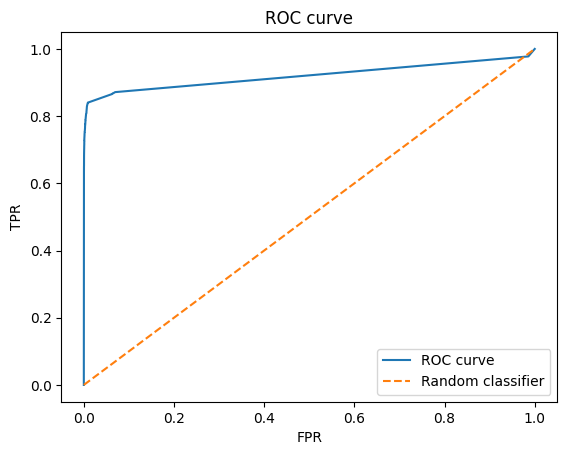

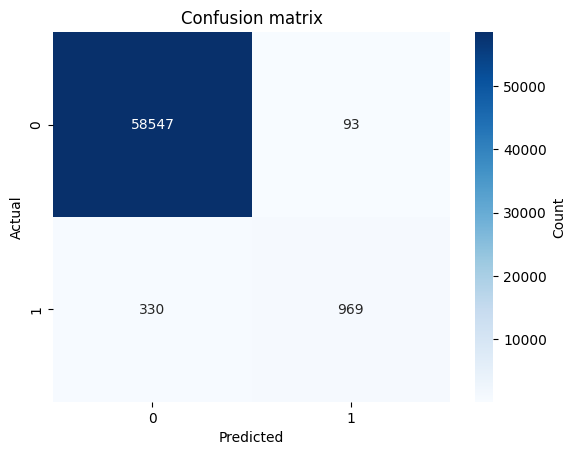

In [65]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

У Optuna большие трудности с данной задачей что для библиотечной модели, что для кастомной - судя по всему, базовые параметры являются самыми оптимальными.

# Выводы

Кастомные реализации деревьев решений показали результаты, идентичные библиотечным моделям. Для этого использовался одинаковый random_state. 
Для регрессии (15000 строк) было достаточно копировать данные в функции создания поддеревьев. Для классификации (300 000 строк) пришлось выполнять распараллеливание, а в создание поддеревьев передавать только индексы.

Предобработка данных и подбор гиперпараметров через Optuna с кросс-валидацией показали хороший прирост по метрикам для регресии. Для классификации у кастомной и библиотечной реализации результаты хуже, чем у базовой модели, даже на 100 итерациях.